In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
import math

## Import Data

In [2]:
file1 = pd.HDFStore('/Users/lianglinqian/Desktop/price.h5','r')
file2 = pd.HDFStore('/Users/lianglinqian/Desktop/price 2.h5','r')
hs300 = pd.read_hdf(file2,'hs300')
zz500 = pd.read_hdf(file2, 'zz500')
stock = pd.read_hdf(file2,'110032.SH')
stock = stock.reindex(pd.to_datetime(stock.index))

In [4]:
key = file1.keys()
key2 =file2.keys()
data = {}
data2 = {}

In [5]:
for n in key:
    data[n]=file1[n]
    data[n]['StockValue']=file1[n].stock*100/file1[n].CONVPRICE
    data[n] = data[n].reindex(pd.to_datetime(data[n].index))
    data[n].index.name=n

## percentage of changing price and average chaning price time

In [11]:
count=0
change_price={}
for key_s, value in data.items():
    if sum(abs(value.CONVPRICE.diff())>0.5)>0:
        count += 1
        change_price[key_s]=sum(abs(value.CONVPRICE.diff())>0.5)

In [12]:
float(count)/len(key)

0.367816091954023

In [13]:
float(sum(change_price.values()))/len(change_price.keys())

1.3125

In [17]:
for key_s, value in data.items():
    value['c_return']=value.convBond/value.convBond.shift() -1
    value['s_return']=value.stock/value.stock.shift() -1

In [18]:
not_include = ['/126008.SH','/126009.SH','/126010.SH','/126011.SH','/126012.SH','/126013.SH','/126014.SH']
not_include2=['/126015.SH','/126016.SH','/126017.SH','/126018.SH']
not_include3=['/126019.SH','/115003.SZ','/113012.SH']
not_include=not_include+not_include2+not_include3

When processing the data, we found that some convertible bond has suspended for a while time. It is not proper to use these data to find the correlation between convertible bond return and stock return

## Rolling correlations between convertible bond and stock 

In [19]:
corr_m1= DataFrame()
corr_m3= DataFrame()
corr_m6= DataFrame()
for key_s, bond in data.items():
    bond['1M corr'] = pd.rolling_corr(bond['c_return'],bond['s_return'],21)
    bond['3M corr'] = pd.rolling_corr(bond['c_return'],bond['s_return'],63)
    bond['6M corr'] = pd.rolling_corr(bond['c_return'],bond['s_return'],125)
    corr = bond[['1M corr','3M corr','6M corr']]
    corr = corr.resample('1M').mean()
    corr[np.isinf(corr)]*= 0
    if key_s not in not_include and len(corr.index)>=8:
        corr_m1=pd.concat((corr_m1,corr['1M corr']),axis=1)
        corr_m3=pd.concat((corr_m3,corr['3M corr']),axis=1)
        corr_m6=pd.concat((corr_m6,corr['6M corr']),axis=1)

/Users/lianglinqian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=21).corr(other=<Series>)
/Users/lianglinqian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=63).corr(other=<Series>)
/Users/lianglinqian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=125).corr(other=<Series>)


## Market Benchmark

In [20]:
hs300 = hs300.reindex(pd.to_datetime(hs300.index))
hs300 = hs300['2008':'2018']
hs300_mean = hs300.resample('1M').mean()
zz500 = zz500.reindex(pd.to_datetime(zz500.index))
zz500 = zz500['2008':'2018']
zz500_mean = zz500.resample('1M').mean()

In [21]:
corr={}
corr['1M']=corr_m1
corr['3M']=corr_m3
corr['6M']=corr_m6
corr_mean ={k: v.mean(1) for k,v in corr.items()}

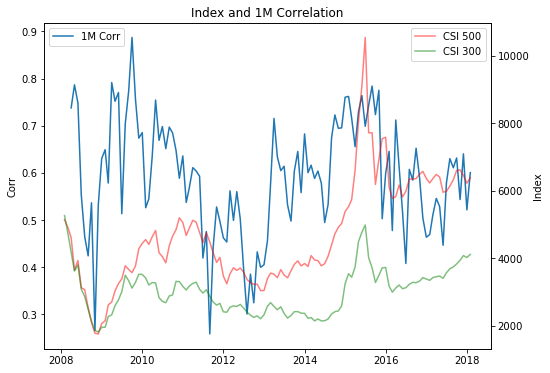

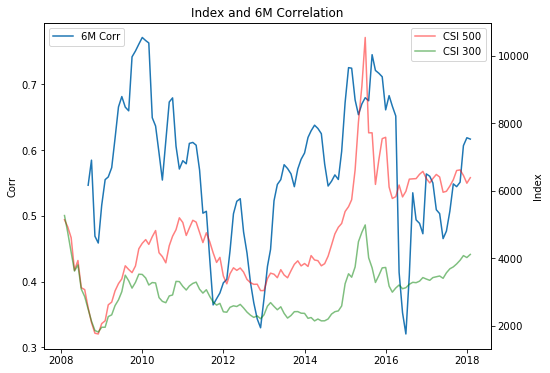

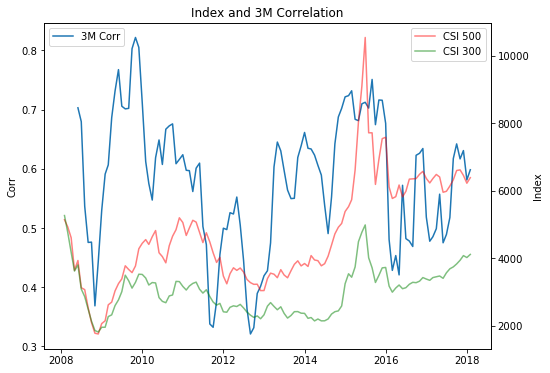

In [22]:
for k,v in corr_mean.items():
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(v,label=k+' Corr')
    ax.set_ylabel('Corr')
    ax.legend(loc=2)
    ax2 = ax.twinx()
    ax2.plot(zz500_mean,label='CSI 500',color='r',alpha=0.5)
    ax2.plot(hs300_mean,label='CSI 300',color='g',alpha=0.5)
    ax2.set_ylabel('Index')
    ax2.legend(loc=1)
    ax2.set_title('Index and '+k+' Correlation')
    plt.show()

In [23]:
conv_price=DataFrame()
for k,v in data.items():
    conv_price=pd.concat((conv_price,v.convBond),axis=1)
conv_price['mean'] = conv_price.apply(np.mean,axis=1)

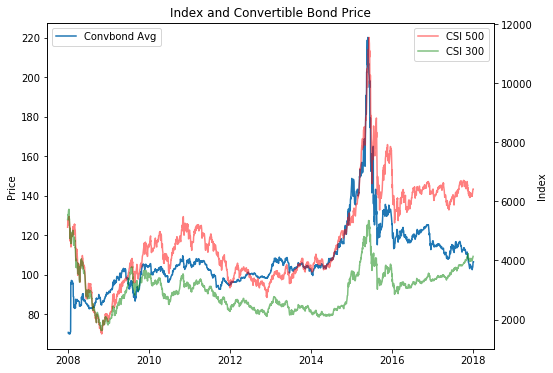

In [24]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(conv_price['mean'],label='Convbond Avg')
ax.set_ylabel('Price')
ax.legend(loc=2)
ax2 = ax.twinx()
ax2.plot(zz500,label='CSI 500',color='r',alpha=0.5)
ax2.plot(hs300,label='CSI 300',color='g',alpha=0.5)
ax2.set_ylabel('Index')
ax2.legend(loc=1)
ax2.set_title('Index and Convertible Bond Price')
plt.show()

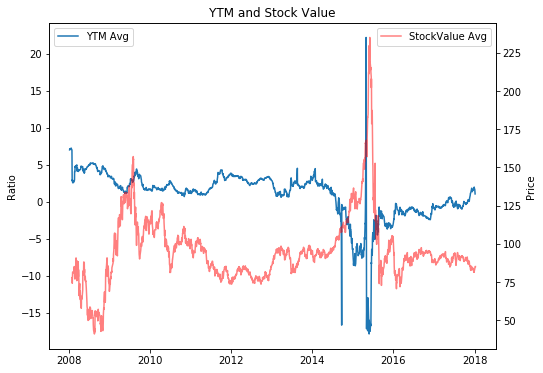

In [25]:
conv_ytm=DataFrame()
conv_stock = DataFrame()
for k,v in data.items():
    conv_ytm=pd.concat((conv_ytm,v.YTM_CB),axis=1)
    conv_stock=pd.concat((conv_stock,v.StockValue),axis=1)
conv_ytm['mean'] = conv_ytm.apply(np.mean,axis=1)
conv_stock['mean'] = conv_stock.apply(np.mean,axis=1)
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(conv_ytm['mean'],label='YTM Avg')
ax.set_ylabel('Ratio')
ax.legend(loc=2)
ax2 = ax.twinx()
ax2.plot(conv_stock['mean'],label='StockValue Avg',color='r',alpha=0.5)
ax2.set_ylabel('Price')
ax2.legend(loc=1)
ax2.set_title('YTM and Stock Value')
plt.show()